Experiments using datasets from https://linkinghub.elsevier.com/retrieve/pii/S001048252030528X

In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [6]:
import libdatasets; reload(libdatasets); from libdatasets import *

In [104]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("hiv", lambda: lru_cache()(hiv)()),
        ("mutagen", lambda: lru_cache()(mutagen)()),
        *[
            (f"muv {dataset}", lambda: lru_cache()(MUV)(dataset)) for dataset in [466, 548, 600, 644, 652, 689, 692, 712, 713, 733, 737, 810, 832, 846, 852, 858, 859]
        ],
        ("sider", lambda: lru_cache()(sider)()),
        *[
            (f"tox21 {dataset}", lambda: lru_cache()(tox21)(dataset)) for dataset in ['nr-ahr','nr-ar-lbd','nr-aromatase','nr-ar','nr-er-lbd','nr-er','nr-ppar-gamma','sr-are','sr-atad5','sr-hse','sr-mmp','sr-p53']
        ],
        
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        #("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        #"labelled_size": 0.1,
        "n_runs": 1
    }
}

In [3]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        *[
            (f"muv {dataset}", lambda: lru_cache()(MUV)(dataset)) for dataset in [466, 548, 600, 644, 652, 689, 692, 712, 713, 733, 737, 810, 832, 846, 852, 858, 859]
        ],
        
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        #("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.08,
        "test_size": 0.75,
        "n_runs": 1,
        "ensure_y": True
    }
}

In [6]:
results = librun.run(matrix, workers=2)

## BBBP, HIV, Mutagen, sider, tox21

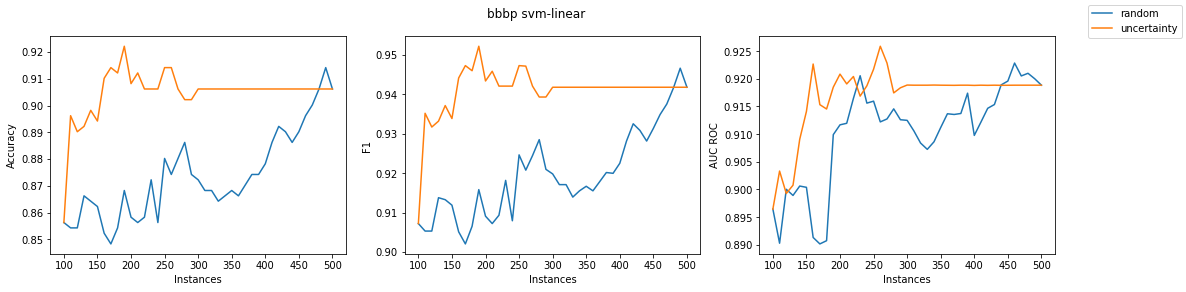

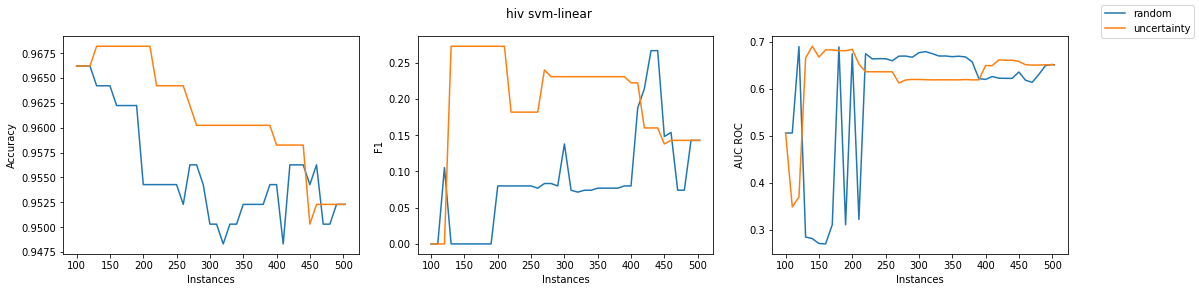

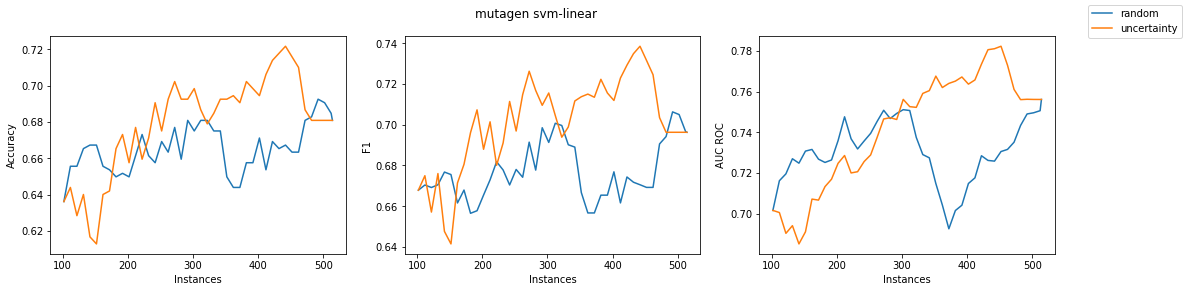

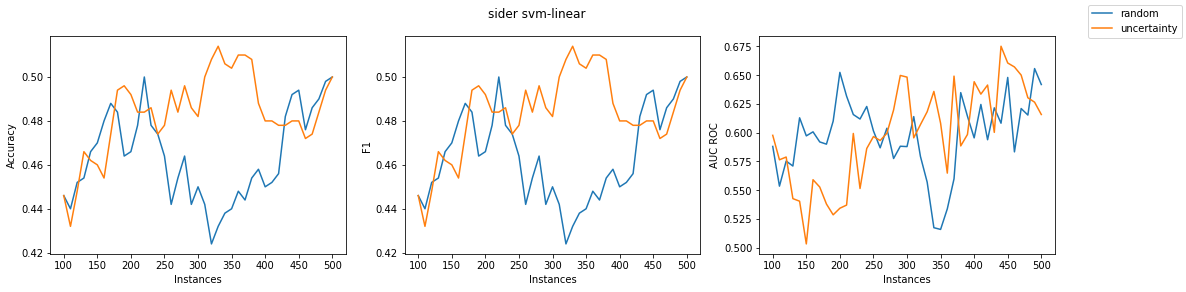

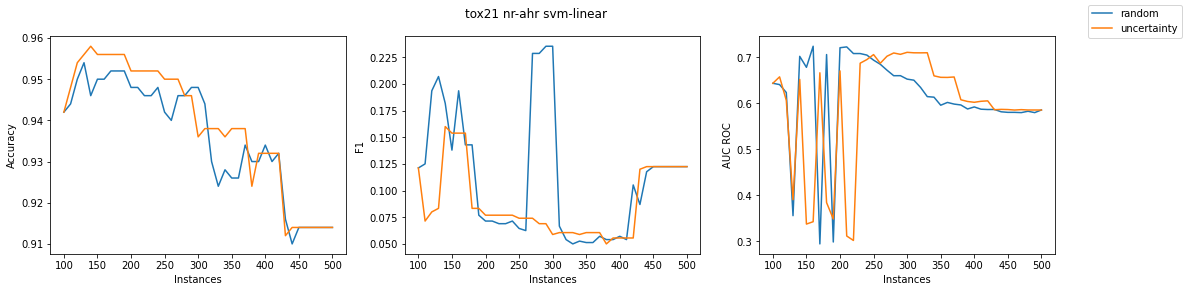

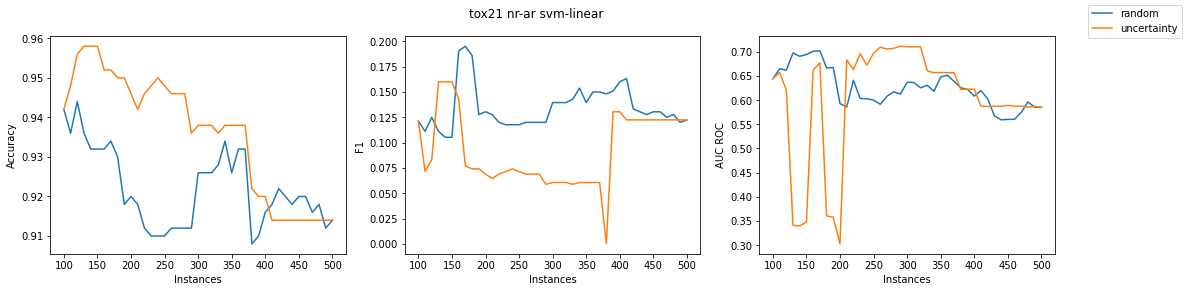

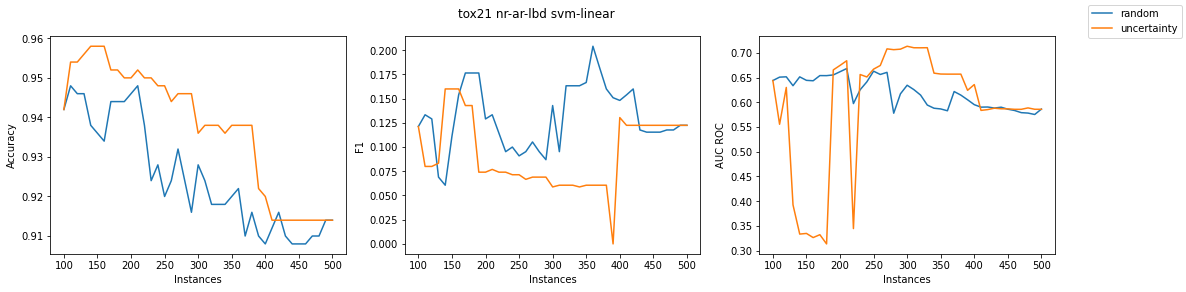

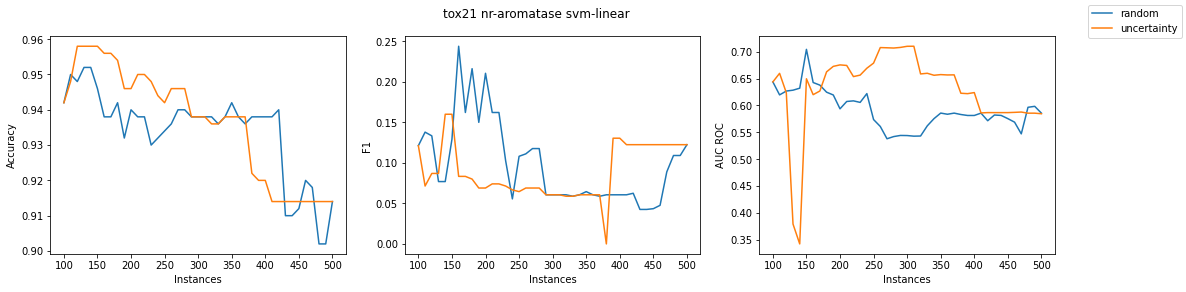

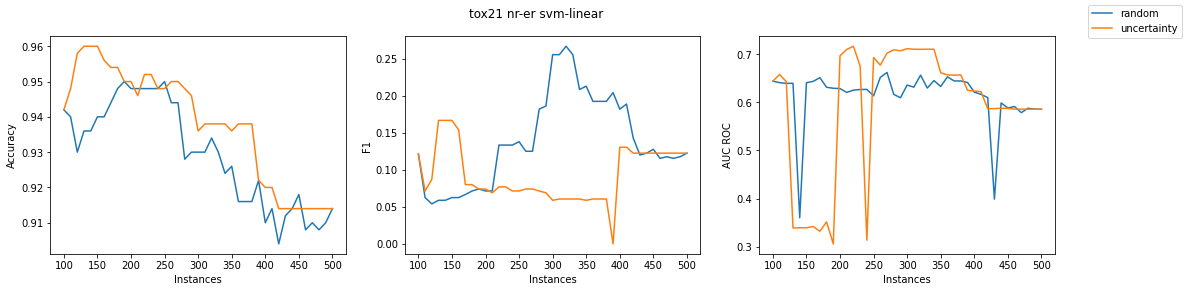

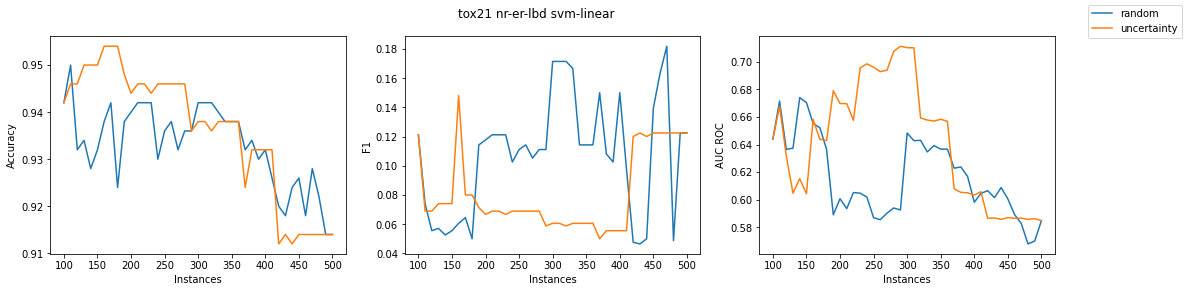

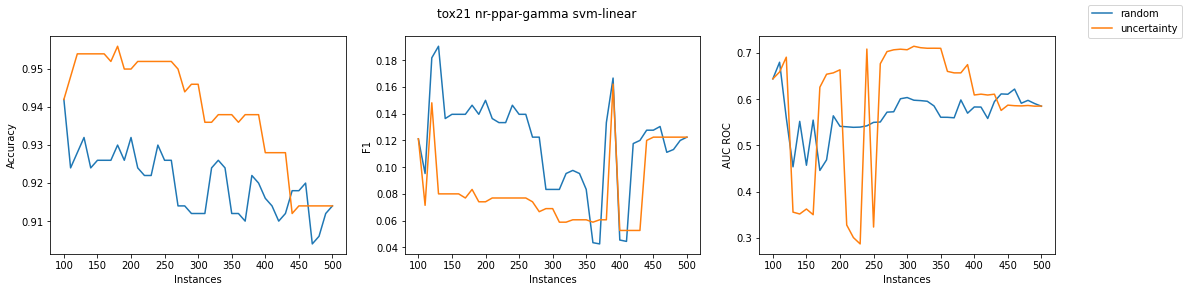

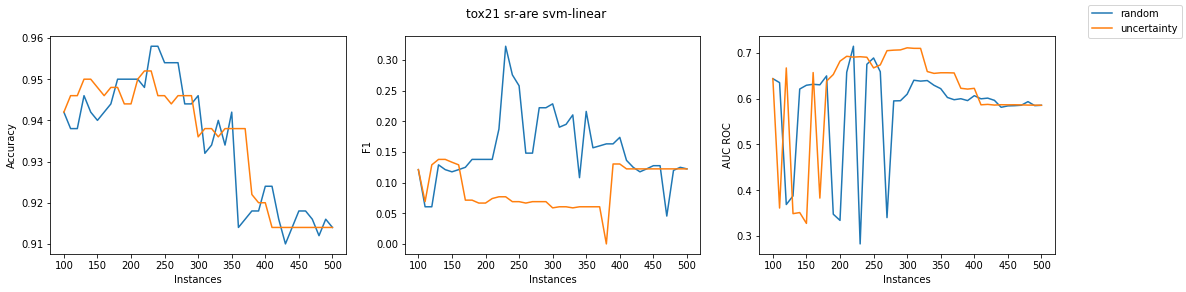

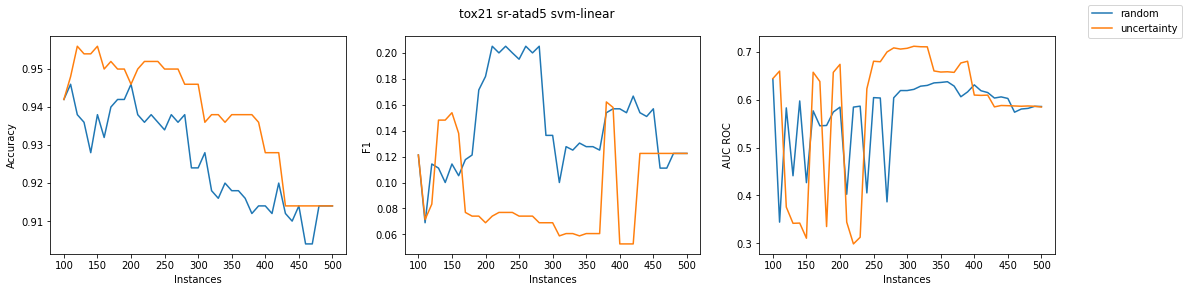

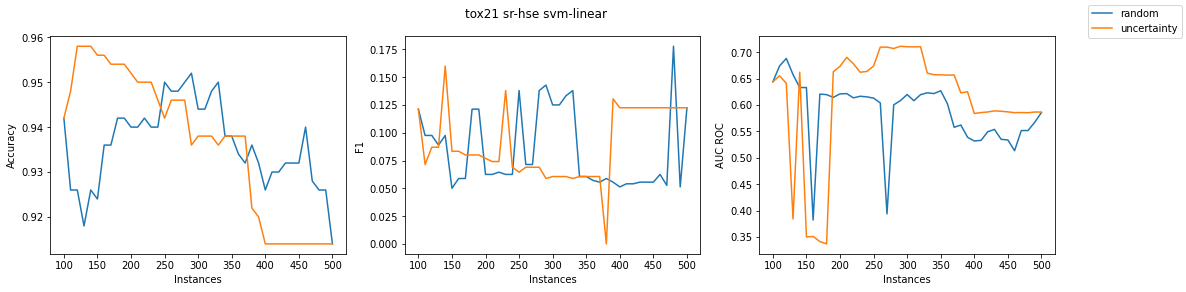

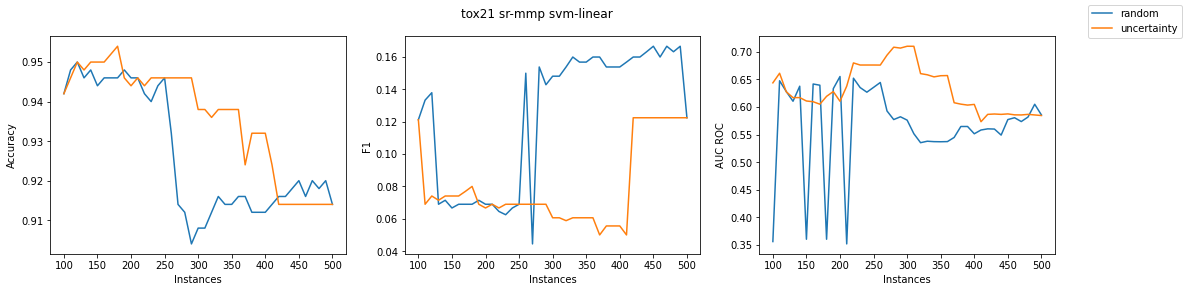

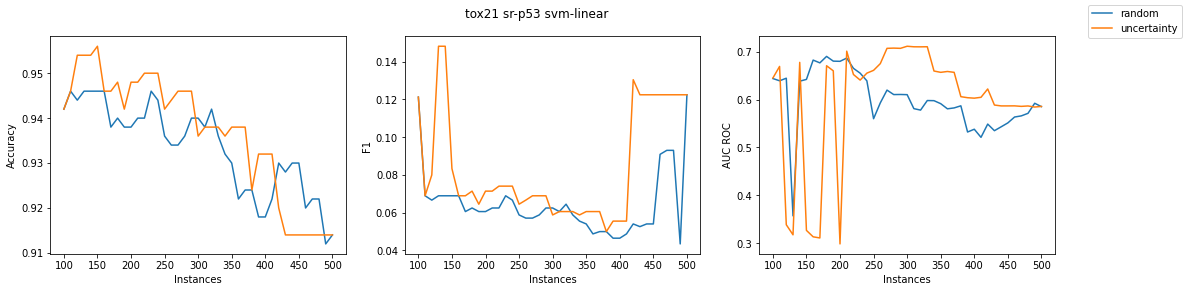

In [84]:
librun.plot(results)

## MUV

Changing the regularlisation parameter doesn't seem to help, I think these datasets just aren't well-suited for active learning. It's possible a 'worse' lower-dimensionality feature representation would be better? This one is 512 continuous features.

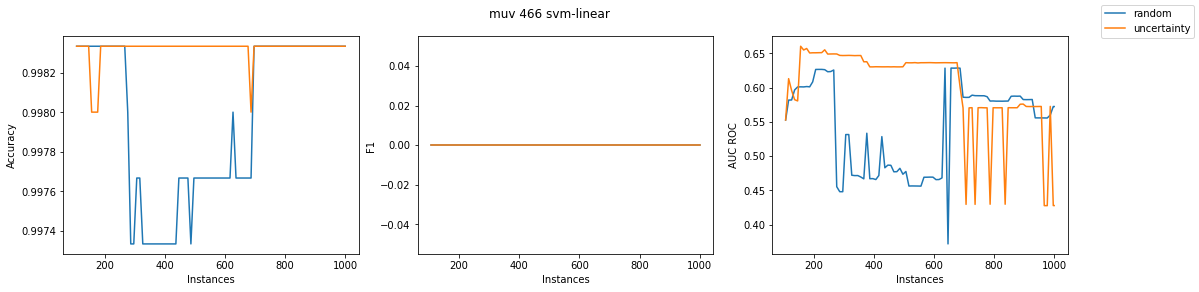

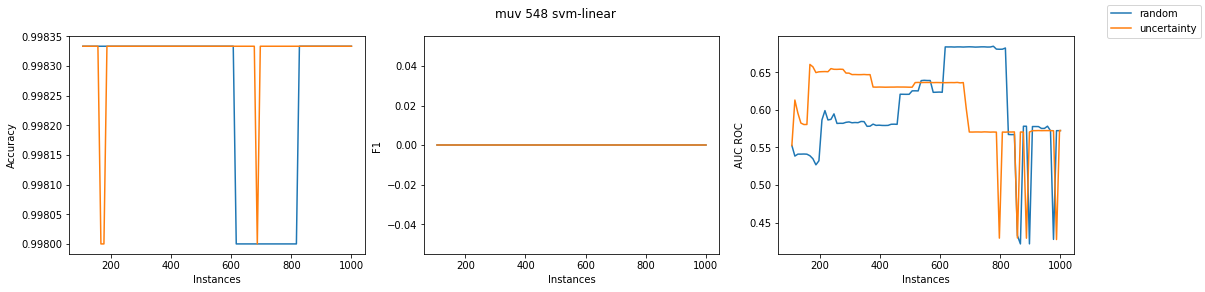

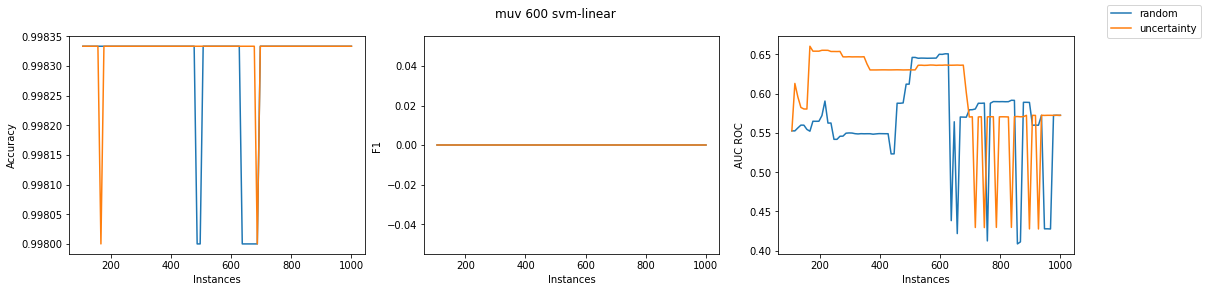

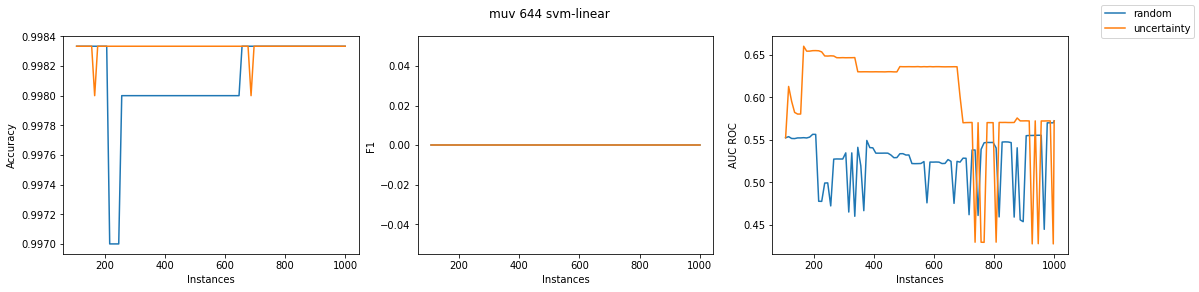

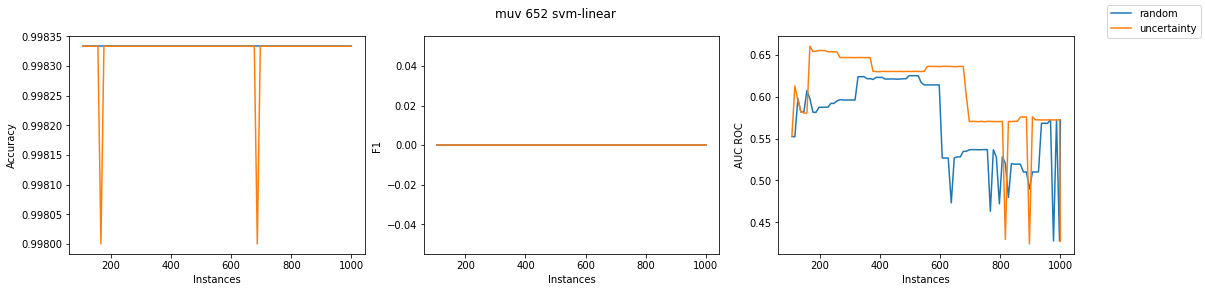

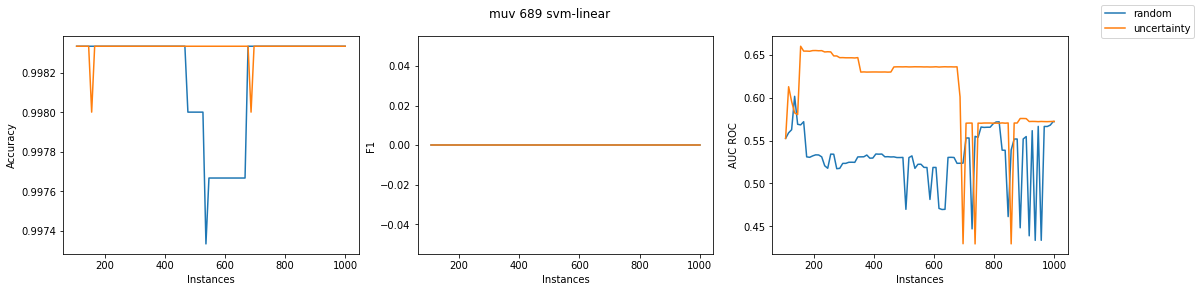

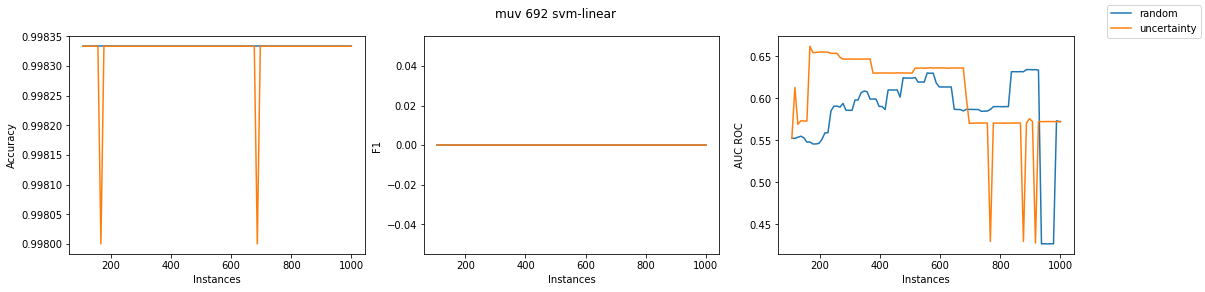

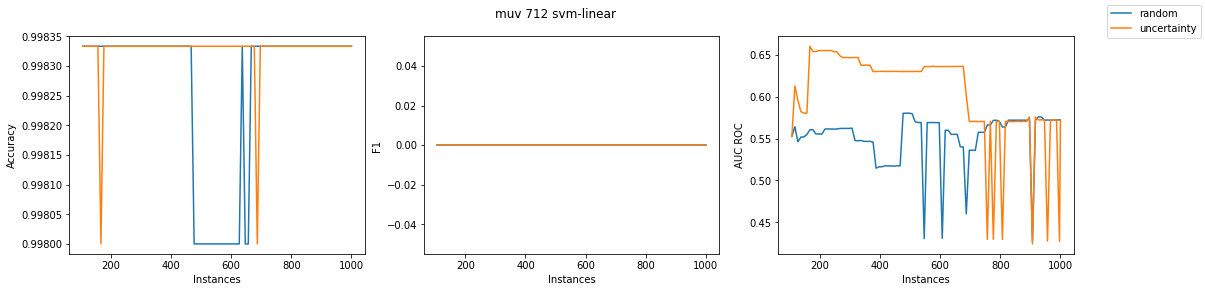

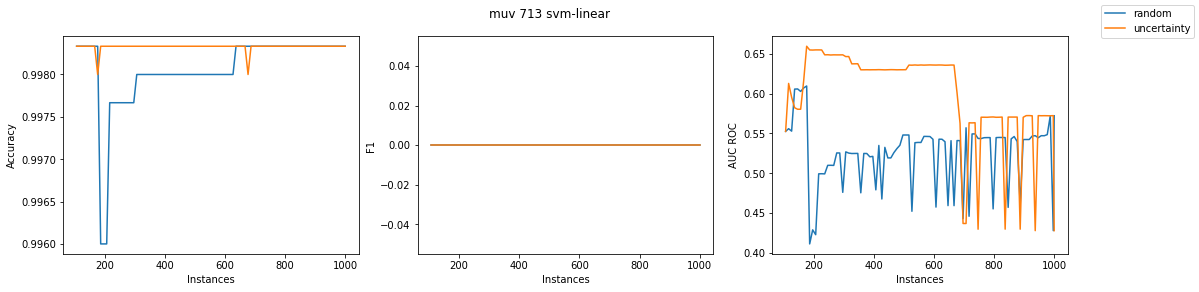

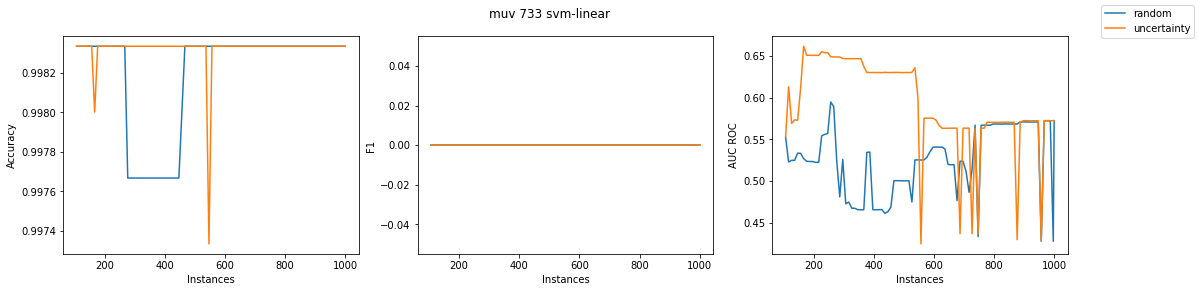

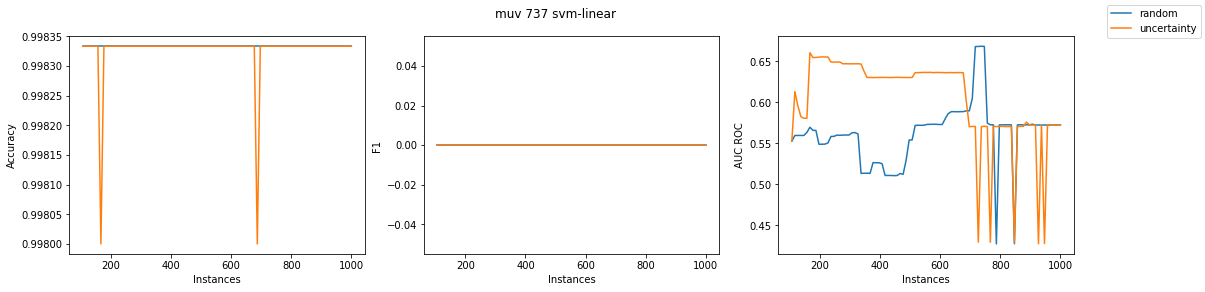

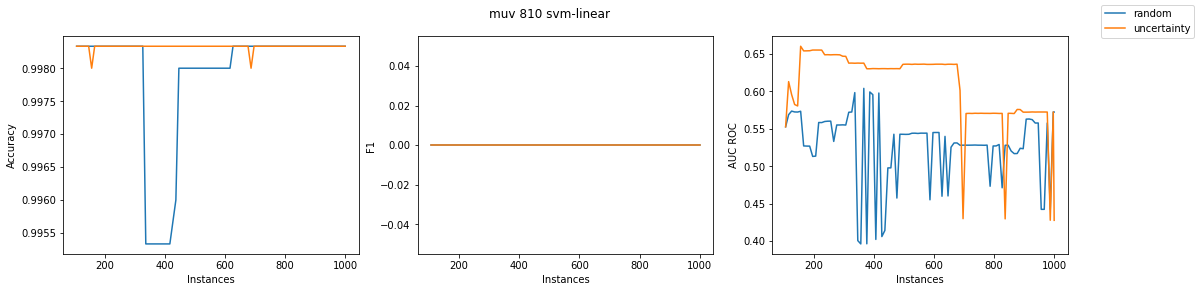

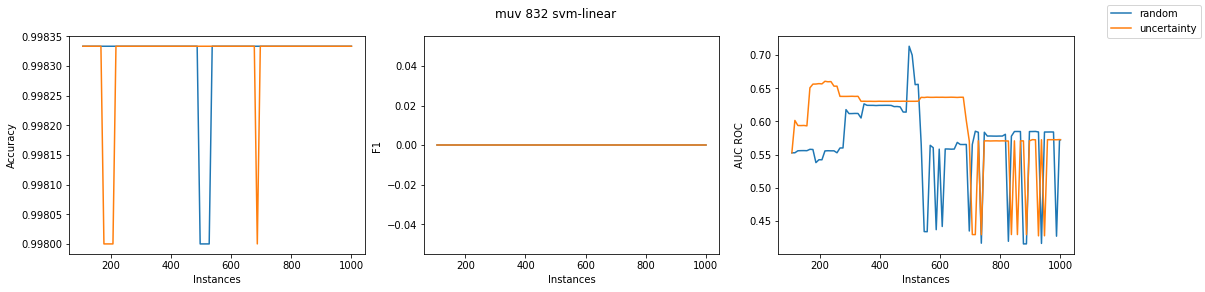

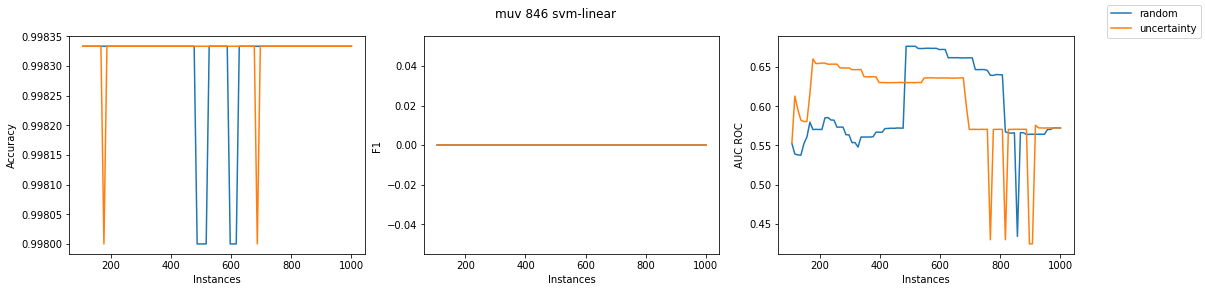

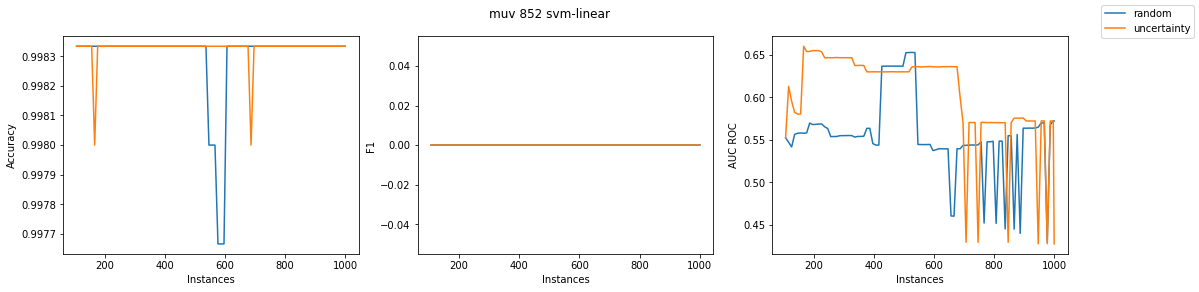

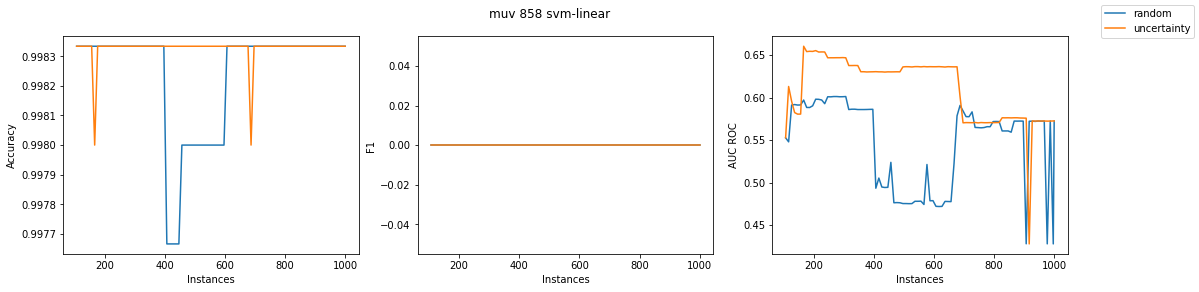

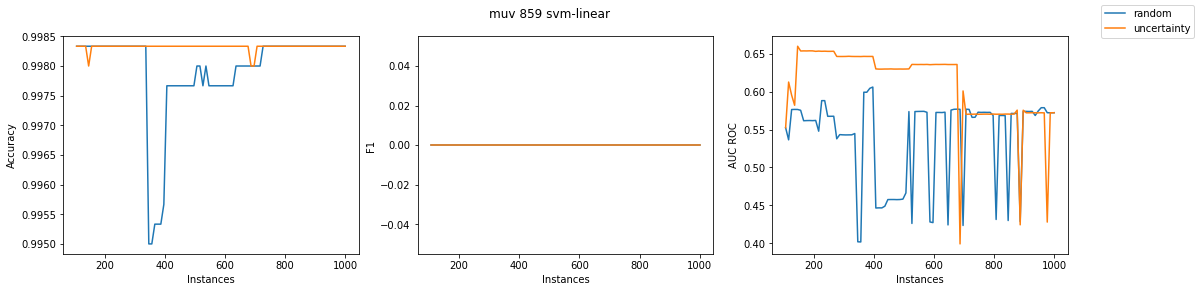

In [149]:
librun.plot(results)

In [8]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("hiv", lambda: lru_cache()(hiv)()),
        ("mutagen", lambda: lru_cache()(mutagen)()),        
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 10
    }
}

In [9]:
results = librun.run(matrix, workers=3)

In [9]:
from collections import Counter

In [10]:
Counter(bbbp()[1])

Counter({1: 777, 0: 224})

In [12]:
Counter(hiv()[1])

Counter({0: 972, 1: 34})

In [13]:
Counter(mutagen()[1])

Counter({1: 555, 0: 473})

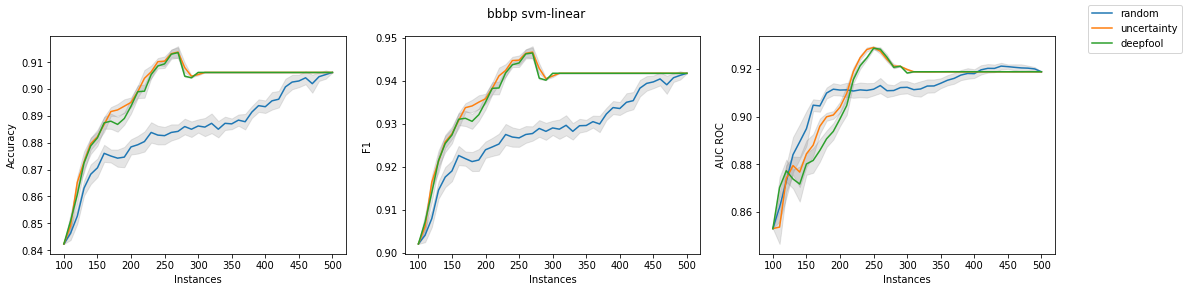

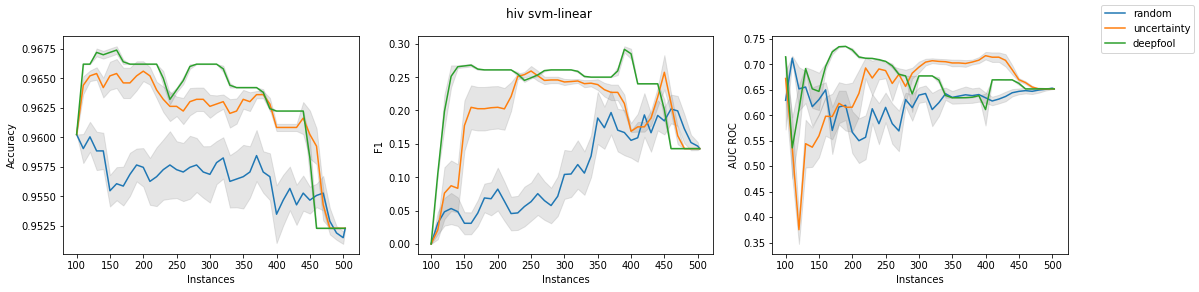

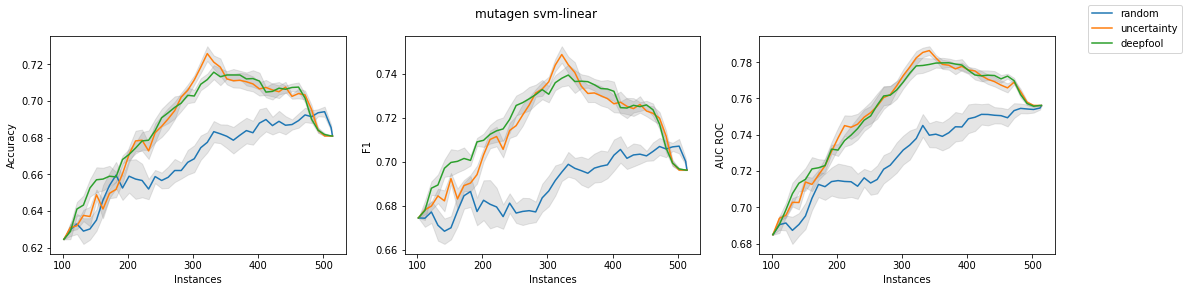

In [10]:
librun.plot(results)

In [11]:
librun.table(results)

bbbp
╒═════════════╤═══════════╤════════════╤═══════════════╤═════════════════════════════╤════════════════════════════╤═════════╕
│ method      │ AUC LAC   │ AUC LF1C   │ AUC AUC ROC   │ Instances to max accuracy   │ Instances to max AUC ROC   │    Time │
╞═════════════╪═══════════╪════════════╪═══════════════╪═════════════════════════════╪════════════════════════════╪═════════╡
│ uncertainty │ 1.02±0    │ 1.01±0     │ 1.00±0        │ 230±10                      │ 220±0                      │         │
├─────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼─────────┤
│ deepfool    │ 1.02±0    │ 1.01±0     │ 1.00±0        │ 240±10                      │ 230±0                      │ 359.393 │
├─────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼─────────┤
│ random      │ 1.00±0    │ 1.00±0     │ 1.00±0        │ 500±40                      │ 410±30                    